In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
chunks=pd.read_csv('/content/drive/MyDrive/Fraud.csv',chunksize=500000)

df=pd.concat(chunks,ignore_index=True)

In [ ]:
def reduce_mem(df):
    for col in df.select_dtypes(include='int'):
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include='float'):
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

df = reduce_mem(df)


1. Data cleaning including missing values, outliers and multi-collinearity.


*   There are no missing values in this data
*   There are outliers in all numerical columns
*   There is high corelation bewtween newbalanceOrg-newbalanceOrig and oldbalanceDest-newbalanceDest implies that our model learns nothing new having both features present one is enough to train the model as other tells the same story.






In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int16  
 1   type            object 
 2   amount          float32
 3   nameOrig        object 
 4   oldbalanceOrg   float32
 5   newbalanceOrig  float32
 6   nameDest        object 
 7   oldbalanceDest  float32
 8   newbalanceDest  float32
 9   isFraud         int8   
 10  isFlaggedFraud  int8   
 11  day             float32
dtypes: float32(6), int16(1), int8(2), object(3)
memory usage: 315.5+ MB


In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

<Axes: >

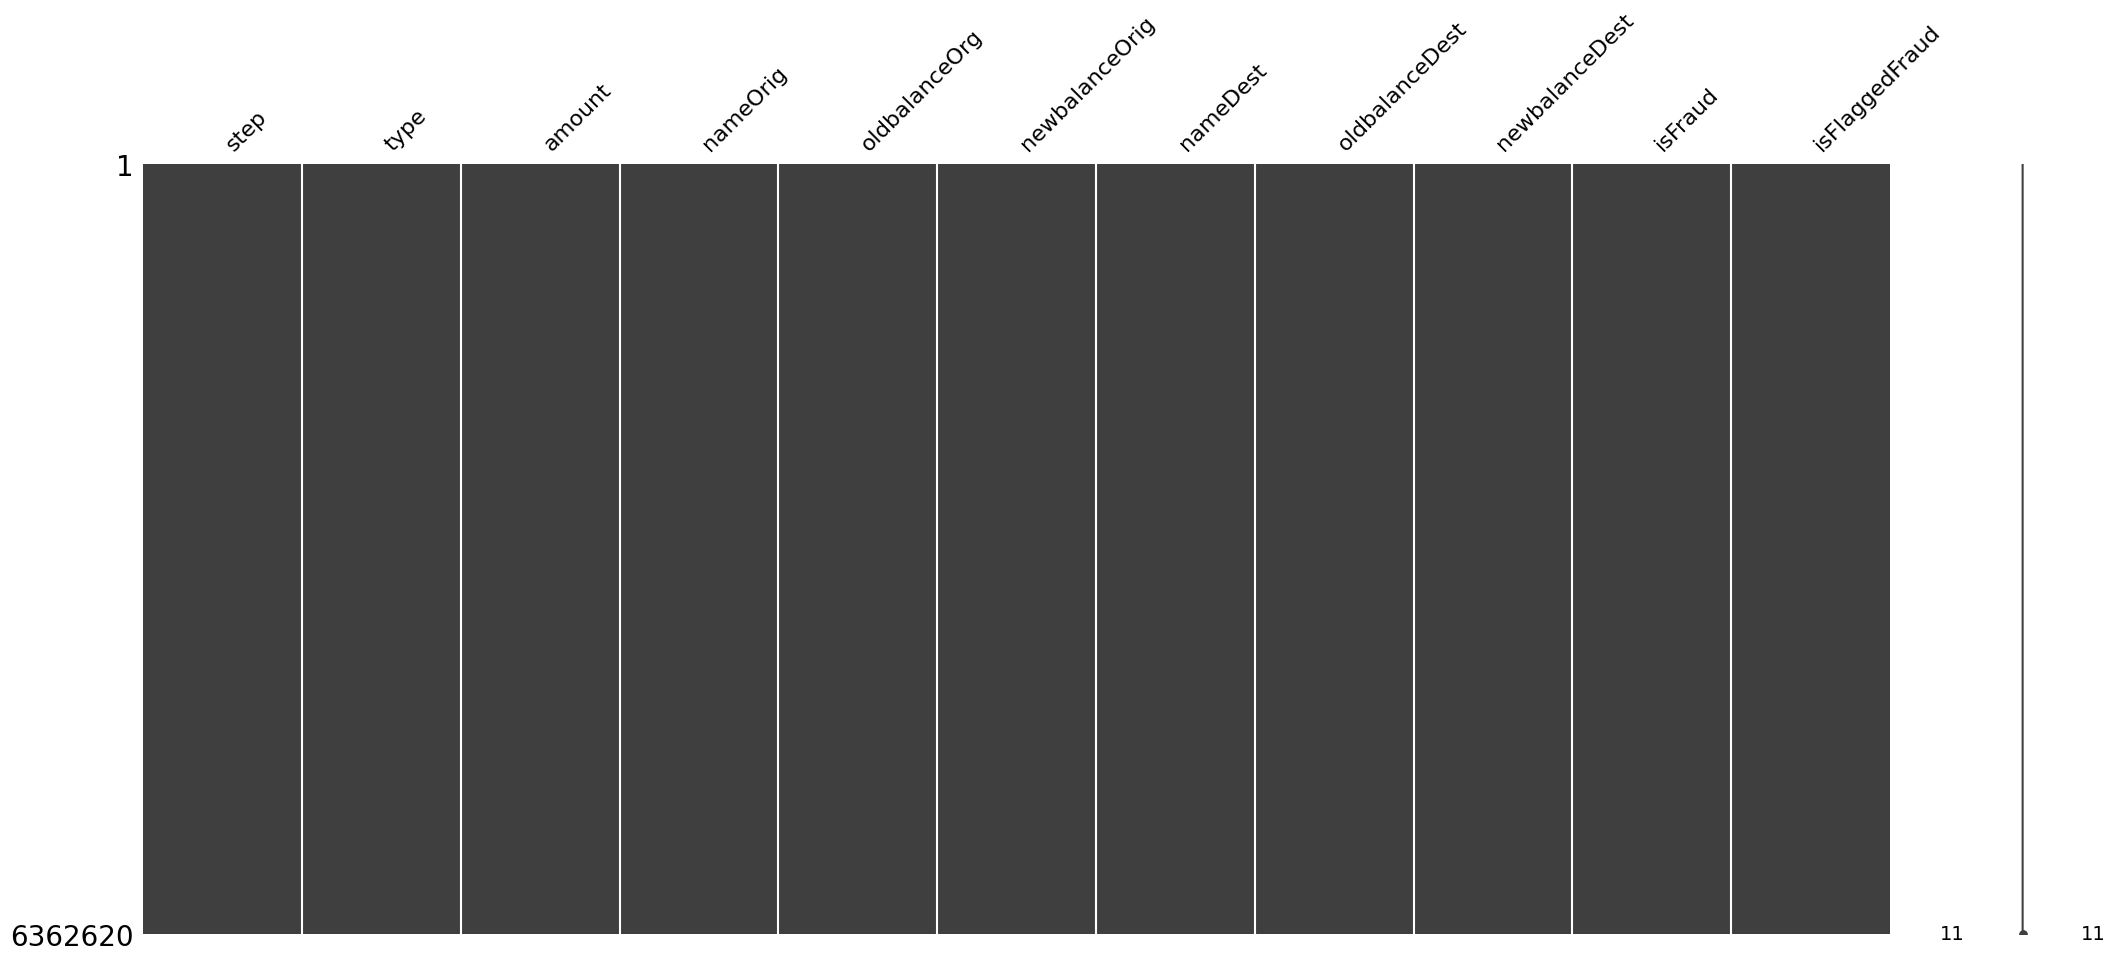

In [ ]:
import missingno as msn
msn.matrix(df)

<Axes: >

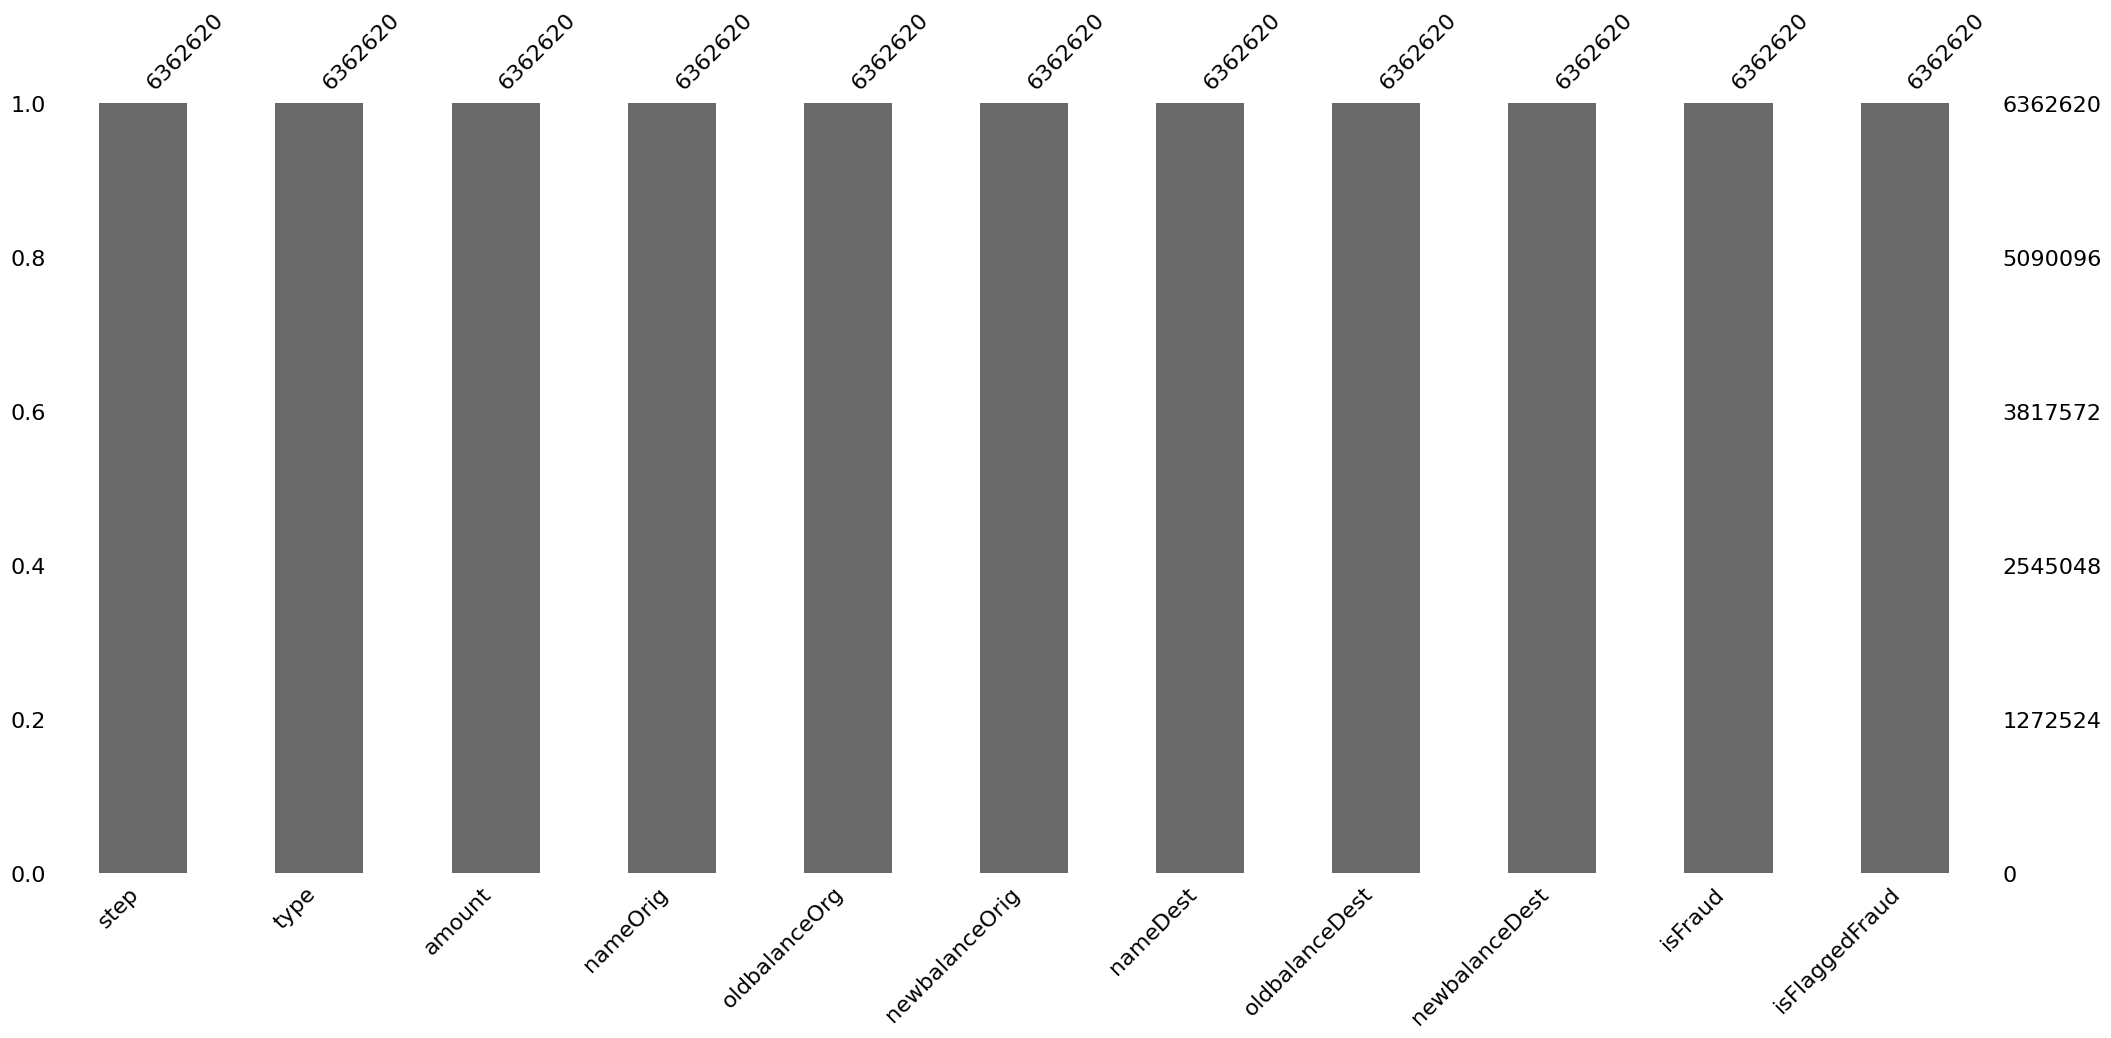

In [ ]:
msn.bar(df)

In [ ]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
0,1,PAYMENT,9.194276,C1231006815,12.044359,11.984786,M1979787155,0.000000,0.0,0,0,1.0
1,1,PAYMENT,7.531166,C1666544295,9.964112,9.872292,M2044282225,0.000000,0.0,0,0,1.0
2,1,TRANSFER,5.204007,C1305486145,5.204007,0.000000,C553264065,0.000000,0.0,1,0,1.0
3,1,CASH_OUT,5.204007,C840083671,5.204007,0.000000,C38997010,9.960954,0.0,1,0,1.0
4,1,PAYMENT,9.364703,C2048537720,10.634773,10.305174,M1230701703,0.000000,0.0,0,0,1.0


In [ ]:
df['day']=np.nan

In [ ]:
for i in range(len(df)):
  df['day'][i]=df['step'][i]//24+1

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1.0


In [ ]:
df.to_csv('/content/drive/MyDrive/Fraud.csv',index=False)

In [ ]:
df['type'].value_counts()

,count
type,
CASH_OUT,2237500
PAYMENT,2151495
CASH_IN,1399284
TRANSFER,532909
DEBIT,41432


In [ ]:
df.groupby(['type','isFraud']).agg(total_amount=('amount','sum'))

total_amount
type     isFraud              
CASH_IN  0        2.363674e+11
CASH_OUT 0        3.884238e+11
         1        5.989202e+09
DEBIT    0        2.271992e+08
PAYMENT  0        2.809337e+10
TRANSFER 0        4.792248e+11
         1        6.067213e+09

All frauds are commited in cash_ot or transfer methods, no fraud is seen in cash_in (ofcourse in most cases they don't commit fraud to add money to account),debit and payment methods.

In [ ]:
df.groupby(['step','type']).agg(total_amount=('isFraud','sum')).nlargest(10,'total_amount')

total_amount
step type                  
212  CASH_OUT            20
     TRANSFER            20
523  CASH_OUT            15
     TRANSFER            15
249  CASH_OUT            14
     TRANSFER            14
387  CASH_OUT            14
     TRANSFER            14
425  CASH_OUT            14
     TRANSFER            14

In [ ]:
df.groupby(['day','type']).agg(total_amount=('isFraud','sum')).nlargest(20,'total_amount')

total_amount
day  type                  
17.0 CASH_OUT           158
     TRANSFER           158
2.0  CASH_OUT           154
3.0  CASH_OUT           153
     TRANSFER           153
2.0  TRANSFER           151
12.0 CASH_OUT           148
     TRANSFER           148
31.0 CASH_OUT           141
     TRANSFER           141
7.0  CASH_OUT           140
     TRANSFER           140
26.0 CASH_OUT           140
     TRANSFER           140
1.0  CASH_OUT           138
10.0 CASH_OUT           138
24.0 CASH_OUT           138
     TRANSFER           138
27.0 CASH_OUT           138
     TRANSFER           138

In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'day'],
      dtype='object')

In [ ]:
df=df.drop(columns=['nameOrig','nameDest'])

In [ ]:
num=df.select_dtypes(include=['int','float'])

In [ ]:
ndf=num
ndf.corr()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000


<Axes: >

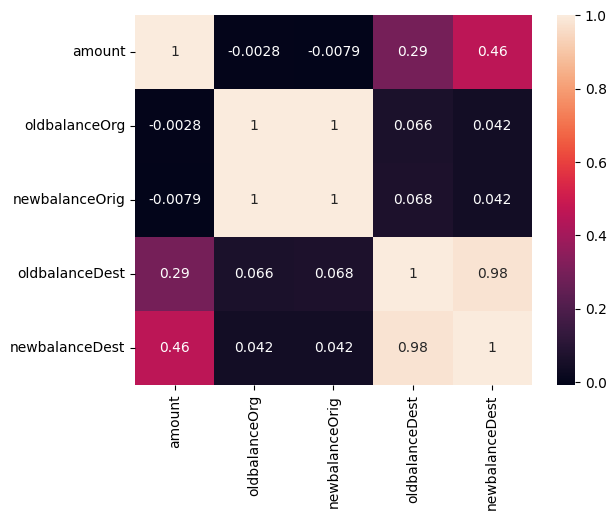

In [ ]:
sns.heatmap(ndf.corr(),annot=True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(ndf)      # Add intercept

# Calculate VIF for each feature
vif_data = pd.DataFrame()

vif_data["Feature"] = X.columns

vif_data["VIF"] = [ variance_inflation_factor(X.values, i)  for i in range (X.shape[1] ) ]

print(vif_data)


          Feature         VIF
0           const    1.249912
1          amount    3.704164
2   oldbalanceOrg  430.052765
3  newbalanceOrig  431.093970
4  oldbalanceDest   64.982048
5  newbalanceDest   74.887727


<Axes: xlabel='step', ylabel='Density'>

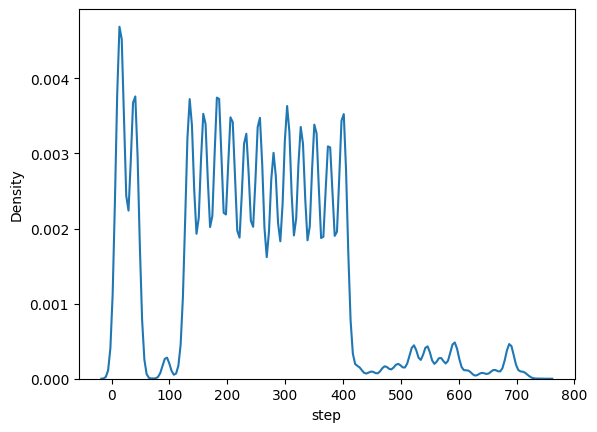

In [ ]:
sns.kdeplot(df['step'])

<Axes: xlabel='step', ylabel='Count'>

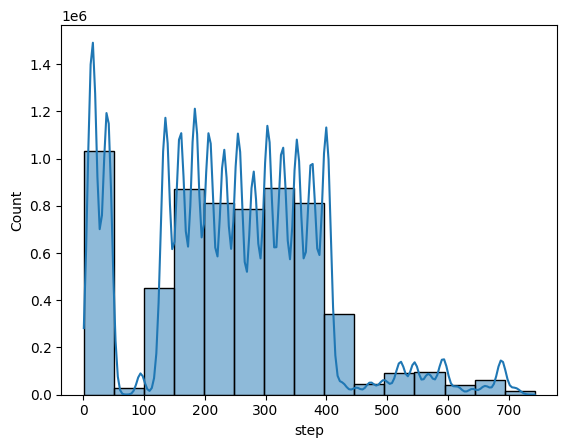

In [ ]:
sns.histplot(df['step'],kde=True,bins=15)

<Axes: xlabel='amount', ylabel='Density'>

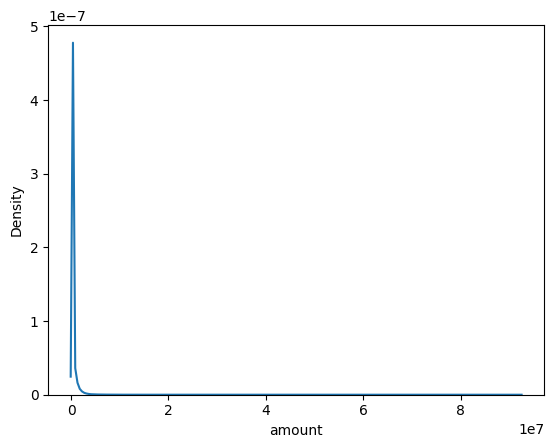

In [ ]:
sns.kdeplot(df['amount'])

<Axes: ylabel='amount'>

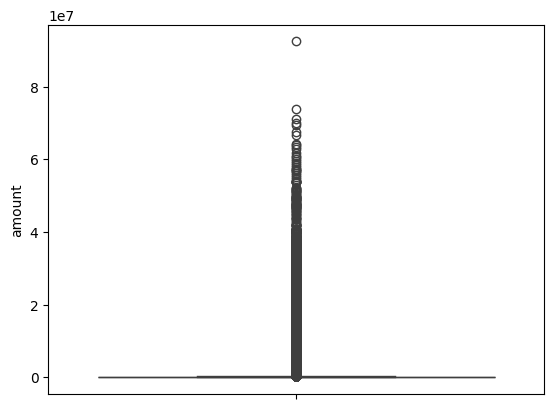

In [ ]:
sns.boxplot(df['amount'])

<Axes: xlabel='oldbalanceOrg', ylabel='Density'>

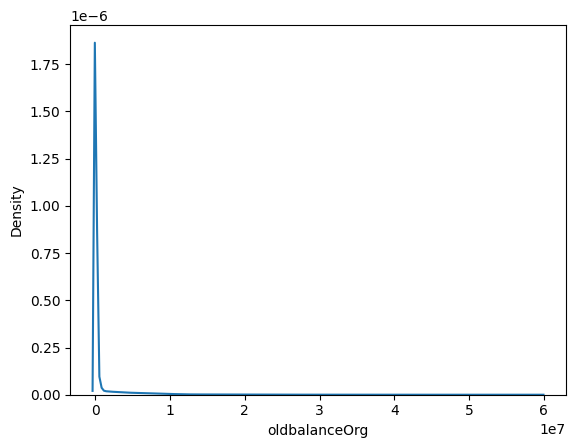

In [ ]:
sns.kdeplot(df['oldbalanceOrg'])

<Axes: ylabel='oldbalanceOrg'>

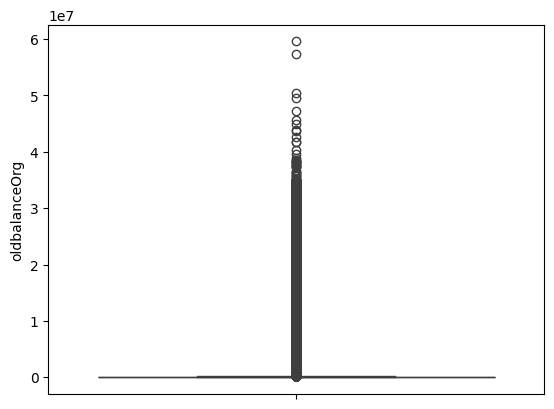

In [ ]:
sns.boxplot(df['oldbalanceOrg'])

<Axes: xlabel='newbalanceOrig', ylabel='Density'>

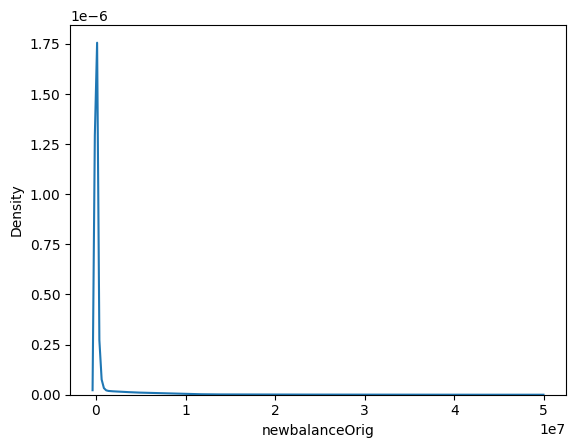

In [ ]:
sns.kdeplot(df['newbalanceOrig'])

<Axes: ylabel='newbalanceOrig'>

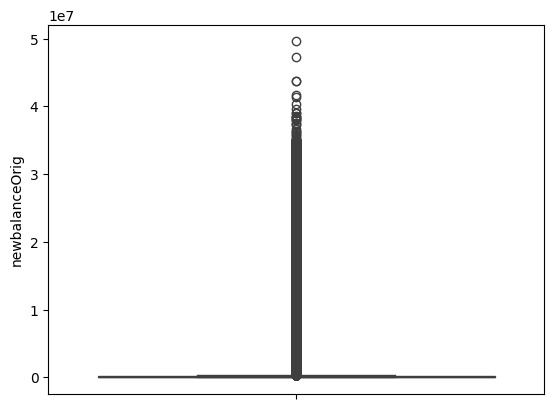

In [ ]:
sns.boxplot(df['newbalanceOrig'])

<Axes: xlabel='oldbalanceDest', ylabel='Density'>

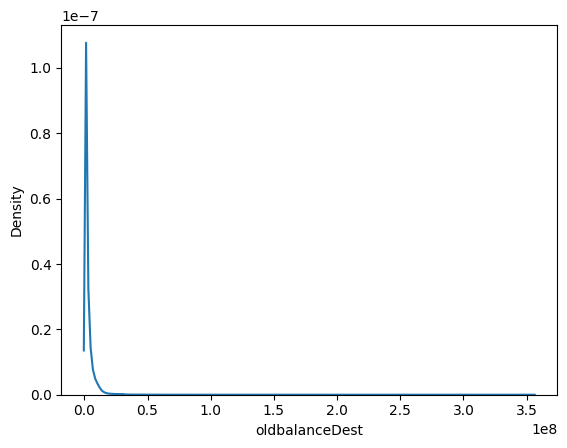

In [ ]:
sns.kdeplot(df['oldbalanceDest'])

<Axes: ylabel='oldbalanceDest'>

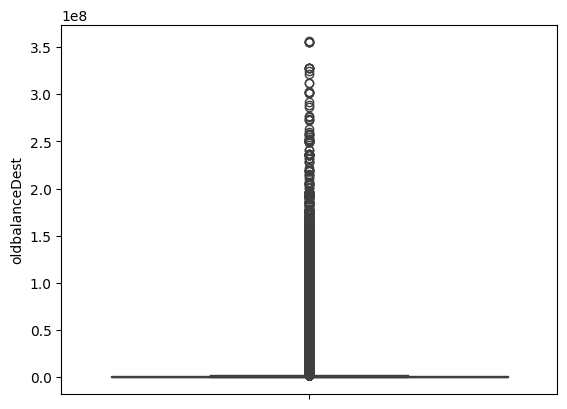

In [ ]:
sns.boxplot(df['oldbalanceDest'])

<Axes: xlabel='newbalanceDest', ylabel='Density'>

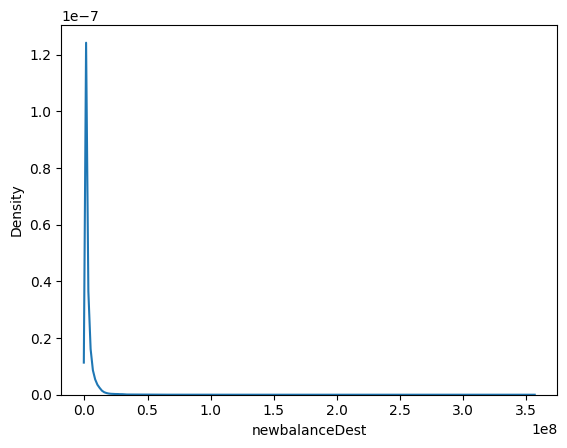

In [ ]:
sns.kdeplot(df['newbalanceDest'])

<Axes: ylabel='newbalanceDest'>

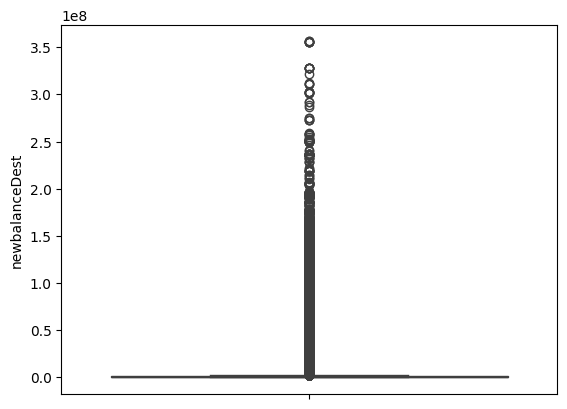

In [ ]:
sns.boxplot(df['newbalanceDest'])

<Axes: xlabel='oldbalanceDest', ylabel='Density'>

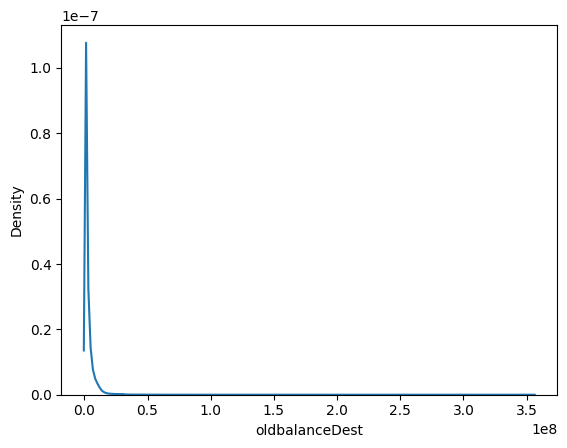

In [ ]:
sns.kdeplot(df['oldbalanceDest'])

<Axes: ylabel='oldbalanceDest'>

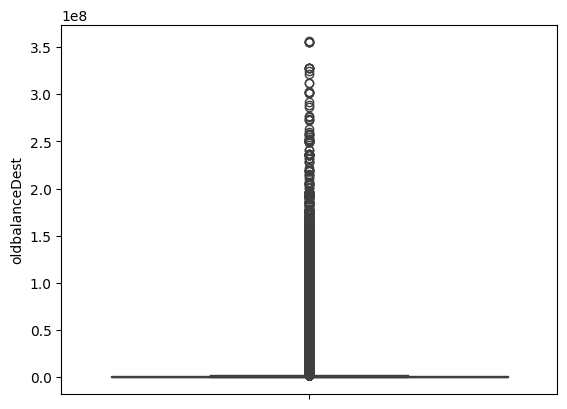

In [ ]:
sns.boxplot(df['oldbalanceDest'])

In [ ]:
# all 5 features are right skewwed and have ouliers so we use transformation onvthem log-normal (simple and easy) or box-cox(if we need normal distribution)

from scipy.stats import boxcox

t=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

for i in t:
  df[i]=np.log1p(df[i])

<Axes: xlabel='amount', ylabel='Density'>

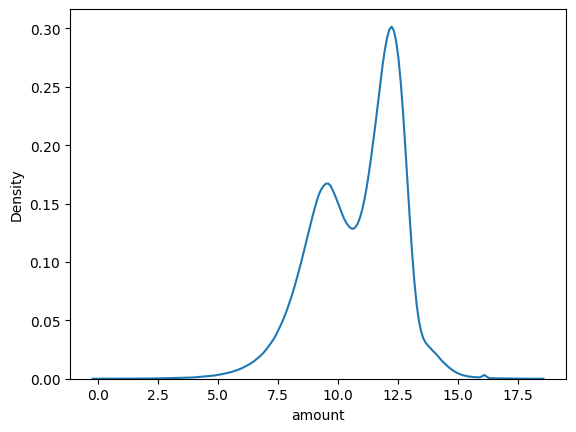

In [ ]:
sns.kdeplot(df['amount'])

In [ ]:
df.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'day'],
      dtype='object')

In [ ]:
df=df.drop(columns=['newbalanceOrig','newbalanceDest'])

In [ ]:
# dependent variable, target variable

x=df.drop('isFraud',axis=1)
y=df['isFraud']

In [ ]:
for i in x.columns:
  print(i,df[i].nunique())

step 743
type 5
amount 2120185
oldbalanceOrg 1277402
oldbalanceDest 1515166
isFlaggedFraud 2
day 31


In [ ]:
x.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,day
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,1.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,1.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,0,1.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,0,1.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,1.0


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

transformer=ColumnTransformer(transformers=[('t1',MinMaxScaler(),[2,4,5,7,8]),('t2',OrdinalEncoder(),[0,1,3,6,9,10])])
x_trans=transformer.fit_transform(x)

col=[]

for i in transformer.get_feature_names_out():
  col.append(i[4:])

x_trans=pd.DataFrame(x_trans,columns=col)
x_trans.head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,step,type,nameOrig,nameDest,isFlaggedFraud,day
0,0.000106,0.002855,0.003233,0.000000,0.0,0.0,3.0,757869.0,1662094.0,0.0,0.0
1,0.000020,0.000357,0.000391,0.000000,0.0,0.0,3.0,2188998.0,1733924.0,0.0,0.0
2,0.000002,0.000003,0.000000,0.000000,0.0,0.0,4.0,1002156.0,439685.0,0.0,0.0
3,0.000002,0.000003,0.000000,0.000059,0.0,0.0,1.0,5828262.0,391696.0,0.0,0.0
4,0.000126,0.000697,0.000603,0.000000,0.0,0.0,3.0,3445981.0,828919.0,0.0,0.0


In [ ]:
from sklearn.feature_selection import chi2,SelectKBest,mutual_info_classif

mutual=mutual_info_classif(x_trans,y)
mutual=pd.Series(mutual,index=x_trans.columns)

mutual.sort_values(ascending=False)


,0
type,0.120120
day,0.091589
step,0.010907
oldbalanceOrg,0.002609
amount,0.002445
nameDest,0.000878
newbalanceOrig,0.000642
oldbalanceDest,0.000181
newbalanceDest,0.000101
isFlaggedFraud,0.000017


In [ ]:
select=SelectKBest(score_func=mutual_info_classif,k=5)
features=select.fit_transform(x_trans,y)
best_features=x_trans.columns[select.get_support()]
best_features

Index(['amount', 'oldbalanceOrg', 'step', 'type', 'day'], dtype='object')

3.How did you select variables to be included in the model?  

Variables were selected using a combination of domain knowledge, multi-collinearity and statistical feature selection. First, high-cardinality identifiers and leakage-prone variables such as nameOrig, isFlaggedFraud, and derived balance columns were removed as they both say samething to model in pairs. The time variable 'step' was transformed into a 'day' feature to capture temporal patterns.

Next, SelectKBest with mutual information (mutual_info_classif) was applied to identify features with the strongest non-linear relationship to fraud. The final variables were chosen based on their predictive power, stability, and relevance to real-world fraud behavior.


In [ ]:
x=x.drop(columns=['step','nameDest','newbalanceOrig','newbalanceDest','isFlaggedFraud','nameOrig'])

6.Do these factors make sense? If yes, How? If not, How not?  

Yes, they make strong practical sense.

*   Transaction type: Fraud gang typically move money using TRANSFER and then CASH_OUT, which matches the dominant fraud pattern in the dataset.

*   High transaction amount: Once an account is compromised, fraudsters try to extract as much  amount as they can usually in large amounts quickly, often close to the available balance.

*   Balance behavior: Legitimate customers rarely empty their accounts suddenly, whereas fraud commonly causes abrupt balance depletion.


*   Low destination balance: Fraudulent transfers often go to new or inactive (fake) accounts with little or no prior balance.


*   Temporal patterns: Fraud attacks tend to occur in bursts during specific time periods, not randomly.

*   These factors align well with real-world fraud behavior, which explains why the model performs strongly and why the predictions are logically interpretable.





In [52]:
x.columns

Index(['type', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'day'], dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=32)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(5090096, 5) (1272524, 5) (5090096,) (1272524,)


In [ ]:
x.sample(10)

,type,amount,oldbalanceOrg,oldbalanceDest,day
3179310,TRANSFER,13.110616,7.632401,11.524153,10.0
2447200,PAYMENT,7.348896,13.497861,0.000000,9.0
5174617,CASH_OUT,13.135232,10.526338,14.682272,15.0
3003933,PAYMENT,6.419148,0.000000,0.000000,10.0
4183585,PAYMENT,9.700022,7.766146,0.000000,13.0
4784480,PAYMENT,9.663502,10.683684,0.000000,15.0
1520138,PAYMENT,10.215421,11.840558,0.000000,7.0
1146906,TRANSFER,12.509024,0.000000,14.201195,6.0
4600185,PAYMENT,10.633064,10.778352,0.000000,14.0
2053823,CASH_IN,11.498188,9.637176,12.109334,8.0


In [ ]:
for i in x.columns:
  print(i,':',x[i].nunique())

type : 5
amount : 2120185
oldbalanceOrg : 1277402
oldbalanceDest : 1515166
day : 31


In [ ]:
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer

transformer=ColumnTransformer(transformers=[('t1',StandardScaler(),[1,2,3]),('t2',OrdinalEncoder(),[0,4])])

x_train_trans=transformer.fit_transform(x_train)
x_test_trans=transformer.transform(x_test)

col=[]

for i in transformer.get_feature_names_out():
  col.append(i[4:])

x_train_trans=pd.DataFrame(x_train_trans,columns=col)
x_test_trans=pd.DataFrame(x_test_trans,columns=col)

x_train_trans.head()

,amount,oldbalanceOrg,oldbalanceDest,type,day
0,0.190254,-1.402389,0.895414,1.0,0.0
1,1.460341,-1.402389,0.913094,4.0,9.0
2,-0.301320,0.529458,0.989678,0.0,13.0
3,-0.643988,0.588853,-1.160628,3.0,1.0
4,-2.016258,0.207864,0.756477,2.0,6.0


In [ ]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [ ]:
df['isFlaggedFraud'].value_counts()

,count
isFlaggedFraud,
0,6362604
1,16


In [ ]:
df.groupby(['isFlaggedFraud','isFraud']).agg({'amount':'sum'})

amount
isFlaggedFraud isFraud              
0              0        1.132337e+12
               1        1.197863e+10
1              1        7.778556e+07

In [ ]:
from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

In [ ]:
from xgboost import XGBClassifier

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=5,
    # Sampling
    subsample=0.8,
    colsample_bytree=0.8,
    # Regularization
    gamma=1.0,
    reg_alpha=1.0,      # L1
    reg_lambda=5.0,    # L2
    # Imbalance handling
    scale_pos_weight=scale_pos_weight,
    # Objective & metric
    objective="binary:logistic",
    eval_metric="aucpr",   # PR-AUC > ROC-AUC for fraud
    # Speed / stability
    tree_method="hist",
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=-1
)


In [ ]:
xgb_model.fit(
    x_train_trans, y_train,
    eval_set=[(x_test_trans, y_test)],
    verbose=False
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=1.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1200,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
y_prob = xgb_model.predict_proba(x_test_trans)[:, 1]

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

f1 = 2 * precision * recall / (precision + recall + 1e-9)
best_threshold = thresholds[f1.argmax()]

best_threshold


np.float32(0.988679)

4.Demonstrate the performance of the model by using best set of tools.


Since this dataset is a highly imbalanced problem, the model was evaluated using precision, recall, F1-score, and PR-AUC instead of accuracy. A confusion matrix was used to analyze false positives and false negatives.

The Precision–Recall curve was the primary evaluation tool, and the decision threshold was optimized to maximize the F1-score rather than using the default 0.5 threshold. After threshold tuning, the model achieved 0.85 precision, 0.81 recall, and 0.83 F1-score for the fraud class, indicating strong fraud detection capability with controlled false alarms.

Accuracy (~99%) was not relied upon due to class imbalance.




In [ ]:
y_pred = (y_prob >= best_threshold).astype(int)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.85      0.81      0.83      1643

    accuracy                           1.00   1272524
   macro avg       0.93      0.90      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524



In [54]:
# Train probabilities
y_prob_train = xgb_model.predict_proba(x_train_trans)[:, 1]
y_pred_train = (y_prob_train >= best_threshold).astype(int)

# Test probabilities
y_prob_test = xgb_model.predict_proba(x_test_trans)[:, 1]
y_pred_test = (y_prob_test >= best_threshold).astype(int)

print("TRAIN")
print(classification_report(y_train, y_pred_train))

print("TEST")
print(classification_report(y_test, y_pred_test))

TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083526
           1       0.85      0.84      0.85      6570

    accuracy                           1.00   5090096
   macro avg       0.93      0.92      0.92   5090096
weighted avg       1.00      1.00      1.00   5090096

TEST
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.85      0.81      0.83      1643

    accuracy                           1.00   1272524
   macro avg       0.93      0.90      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524



2.Describe your fraud detection model in elaboration.


 I built a fraud detection model using XGBoost to identify fraudulent transactions in a highly imbalanced financial dataset(99.83%:0.13%). Fraud mainly involves account takeover, followed by large TRANSFER and CASH-OUT transactions.

During preprocessing, I removed high-cardinality and leakage-prone features such as nameOrig, isFlaggedFraud, and derived balance columns. I converted the hourly step variable into a day feature to capture temporal fraud patterns.

Numerical features were scaled using StandardScaler, and transaction types were encoded using OrdinalEncoder. Feature selection was performed using SelectKBest with mutual information to retain the most informative variables.
XGBoost was chosen for its strong performance on tabular data, ability to model non-linear relationships, and built-in handling of class imbalance via scale_pos_weight. The model was trained using PR-AUC as the evaluation metric with early stopping to prevent overfitting.

Instead of using the default probability threshold, I optimized the decision threshold using the precision–recall curve, which significantly improved fraud recall. The final model achieved a fraud recall of 0.81 and an F1-score of 0.83, making it suitable for real-world fraud prevention where catching fraudulent transactions is critical.


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=200,
    min_samples_split=500,
    class_weight="balanced",
    random_state=42
)

dt.fit(x_train_trans, y_train)


dt_pred=dt.predict(x_test_trans)

dt_report=classification_report(y_test,dt_pred)

print(dt_report)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1270881
           1       0.02      1.00      0.04      1643

    accuracy                           0.94   1272524
   macro avg       0.51      0.97      0.50   1272524
weighted avg       1.00      0.94      0.97   1272524



In [ ]:
from sklearn.tree import export_text
print(export_text(dt, feature_names=x.columns))


|--- amount <= 0.71
|   |--- day <= 16.50
|   |   |--- oldbalanceDest <= 3.50
|   |   |   |--- amount <= 0.39
|   |   |   |   |--- type <= -3.61
|   |   |   |   |   |--- oldbalanceDest <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- oldbalanceDest >  1.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- type >  -3.61
|   |   |   |   |   |--- type <= -2.70
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- type >  -2.70
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- amount >  0.39
|   |   |   |   |--- type <= 0.12
|   |   |   |   |   |--- oldbalanceDest <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- oldbalanceDest >  1.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- type >  0.12
|   |   |   |   |   |--- amount <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- amount >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |--- oldbalanceDest >  3.50
|   |   |   |--- type <= 0.12


In [64]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200,class_weight={0:1,1:774},max_depth=15,n_jobs=-1,random_state=64 )
rfc.fit(x_train_trans,y_train)

'''
rfc_pred=rfc.predict(x_test_trans)

rfc_report=classification_report(y_test,rfc_pred)
print(rfc_report)
'''

'\nrfc_pred=rfc.predict(x_test_trans)\n\nrfc_report=classification_report(y_test,rfc_pred)\nprint(rfc_report)\n'

In [75]:
rfc_cm=confusion_matrix(rfc_pred,y_test)
print(rfc_cm)

[[1270640     517]
 [    241    1126]]


In [68]:
rfc_prob=rfc.predict_proba(x_test_trans)[:,1]

In [69]:
precision, recall, thresholds = precision_recall_curve(y_test, rfc_prob)

f1 = 2 * precision * recall / (precision + recall + 1e-9)
best_threshold = thresholds[f1.argmax()]

best_threshold

np.float64(0.9129176317794844)

In [71]:
rfc_pred = (rfc_prob >= best_threshold).astype(int)
print(classification_report(y_test, rfc_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.82      0.69      0.75      1643

    accuracy                           1.00   1272524
   macro avg       0.91      0.84      0.87   1272524
weighted avg       1.00      1.00      1.00   1272524



5. What are the key factors that predict fraudulent customer?

The key factors that predict fraudulent customers are transaction type, transaction amount, account balance behavior, and temporal patterns. Fraudulent activity is strongly associated with TRANSFER and CASH_OUT transactions, large transaction amounts, sudden depletion of the sender's balance, and recipient accounts with very low initial balances. Additionally, fraud tends to occur in specific time periods, which is captured by the day based feature.



7. What kind of prevention should be adopted while company update its infrastructure?

The company should adopt a layered fraud prevention strategy. This includes deploying a real-time machine learning risk-scoring model (such as the XGBoost model) to evaluate transactions before execution. High-risk transactions—especially large TRANSFER and CASH_OUT events should trigger step-up authentication or temporary holds.

In addition, the system should implement dynamic transaction limits(daily_limit or limit_per_transaction), behavioral monitoring to detect sudden balance depletion, and recipient account profiling to identify mule accounts. Combining ML-based detection with adaptive business rules and human review ensures effective fraud prevention while minimizing disruption to legitimate customers.


8.Assuming these actions have been implemented, how would you determine if they work?


The effectiveness of the implemented fraud prevention measures can be evaluated by tracking fraud recall, precision, and PR-AUC over time, with a focus on reducing false negatives. From a business perspective, key indicators include reduction in fraud losses, fewer successful CASH_OUT frauds, and faster detection time.

Additionally, before and after comparisons and a/b testing can be used to compare the new system against existing rules. Continuous data and model drift monitoring ensures sustained performance and signals when retraining is required.
